# Missing Values and Outliers Imputation
" _Missing values and outliers are frequently encountered while collecting data. The presence of missing values reduces the data available to be analyzed, compromising the statistical power of the study, and eventually the reliability of its results. In addition, it causes a significant bias in the results and degrades the efficiency of the data. Outliers significantly affect the process of estimating statistics (e.g., the average and standard deviation of a sample), resulting in overestimated or underestimated values. Therefore, the results of data analysis are considerably dependent on the ways in which the missing values and outliers are processed. In this regard, this review discusses the types of missing values, ways of identifying outliers, and dealing with the two._ " -https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5548942/

## Heart Failure Dataset

### Imports and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

### Missing Value Imputation

{'age': 0, 'anaemia': 0, 'creatinine_phosphokinase': 0, 'diabetes': 0, 'ejection_fraction': 0, 'high_blood_pressure': 0, 'platelets': 0, 'serum_creatinine': 0, 'serum_sodium': 0, 'sex': 0, 'smoking': 0, 'time': 0, 'DEATH_EVENT': 0}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

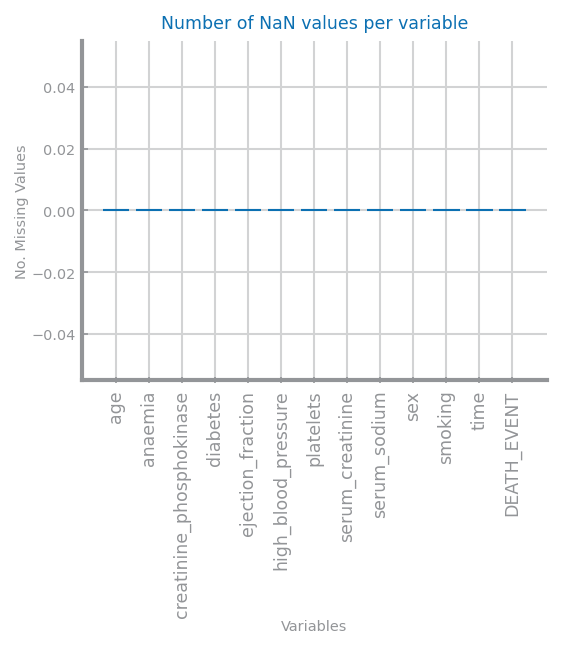

In [2]:
missing_values = {}
for var in data:
    missing_values[var] = data[var].isna().sum()
    
print(missing_values)

plt.figure()

ds.bar_chart(missing_values.keys(), missing_values.values(), title='Number of NaN values per variable',
               xlabel='Variables',
               ylabel='No. Missing Values')

plt.xticks(rotation=90)
#plt.ylim(bottom=0)

This dataset contains no missing values!

### Outliers Imputation - Identification

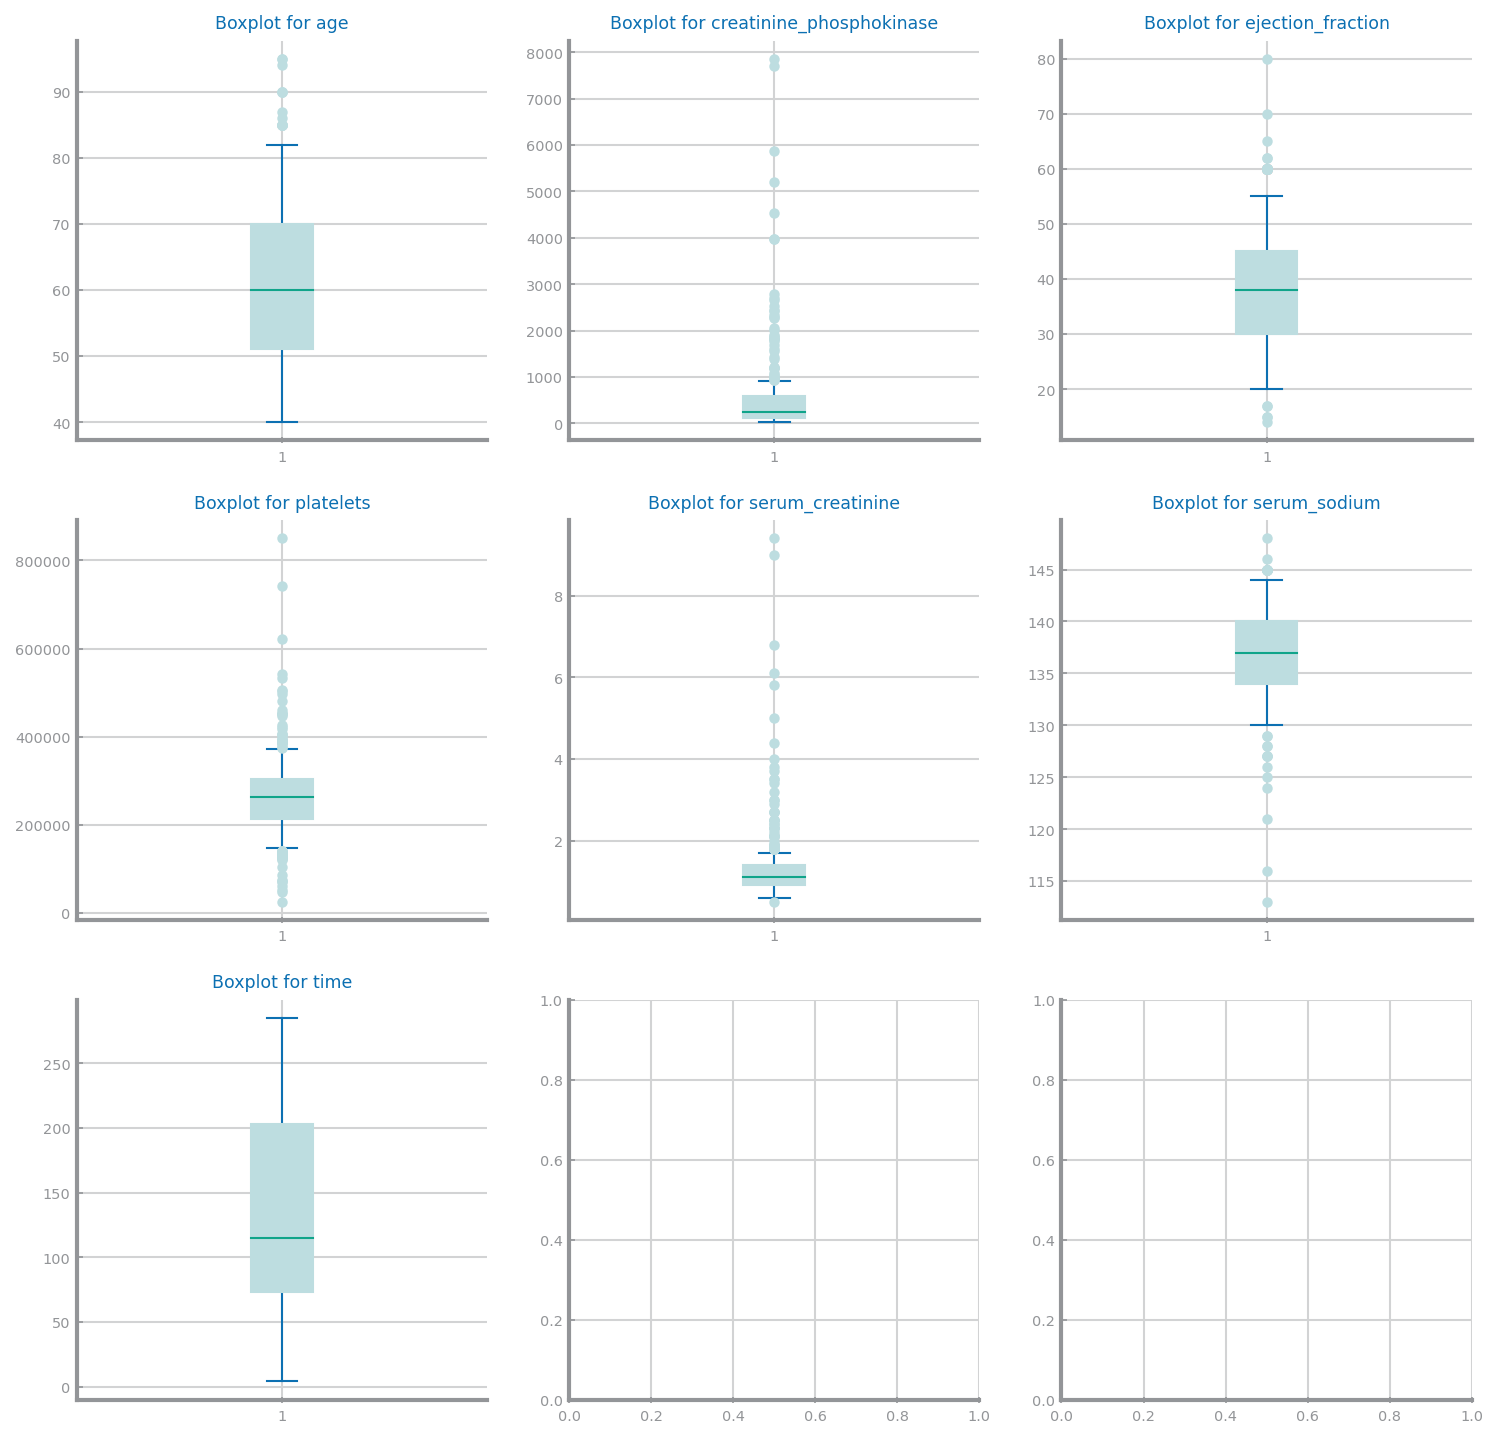

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0,75.0,582,20,265000.00,1.9,130,4
1,55.0,7861,38,263358.03,1.1,136,6
2,65.0,146,20,162000.00,1.3,129,7
3,50.0,111,20,210000.00,1.9,137,7
4,65.0,160,20,327000.00,2.7,116,8


In [3]:
numeric_vars = data.select_dtypes(include='number').columns
rows, cols = ds.choose_grid(7) #numero de variaveis non bolean
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0

numeric_data = data
binary_data = data

off=0
for n in range(len(numeric_vars)):
    num_unique = len(list(set(data[numeric_vars[n]].values)))
    #only boxplot non boolean vars
    if num_unique == 2:
        off+=1
        numeric_data = numeric_data.drop(columns=[data.columns[n]], axis=1) #Remove binary columns

    else:
        binary_data = binary_data.drop(columns=[data.columns[n]], axis=1) #Remove non-binary columns

        axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
        axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n+1-off) % cols == 0 else (i, j + 1)
plt.show()

numeric_data.head()

By looking at the prior Box Plots for our dataset's numeric variables we can clearly note the presence of outliers on all variables except for Time. On the next sections we'll see how we can treat these.

There are basically three methods for treating outliers in a data set. One method is to **remove outliers** as a means of trimming the data set. Another method involves **replacing the values of outliers or reducing the influence of outliers** through outlier weight adjustments. The third method is used to **estimate the values of outliers** using robust techniques.

In [4]:
def draw_boxplots(data):
    numeric_vars = data.select_dtypes(include='number').columns
    rows, cols = ds.choose_grid(7) #numero de variaveis non bolean
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    i, j = 0, 0

    numeric_data = data
    binary_data = data

    off=0
    for n in range(len(numeric_vars)):
        num_unique = len(list(set(data[numeric_vars[n]].values)))
        #only boxplot non boolean vars
        if num_unique == 2:
            off+=1
            numeric_data = numeric_data.drop(columns=[data.columns[n]], axis=1) #Remove binary columns

        else:
            binary_data = binary_data.drop(columns=[data.columns[n]], axis=1) #Remove non-binary columns

            axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
            axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
            i, j = (i + 1, 0) if (n+1-off) % cols == 0 else (i, j + 1)
    plt.show()

    numeric_data.head()

### Outliers Imputation - Trimming

" _Under this approach, a data set that excludes outliers is analyzed. The trimmed estimators such as mean decrease the variance in the data and cause a bias based on under- or overestimation. Given that the outliers are also observed values, excluding them from the analysis makes this approach inadequate for the treatment of outliers._ "

Lets start by treating our outliers by simply removing any row that posesses outliers in any column from our dataset. This isn't particularly optimal as explained above, but its easy and fast to do and indeed does get rid of the outliers

#### Using Z-Scores
The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [5]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

z_scores = np.abs(stats.zscore(data))

print("Before removing outliers:", data.shape)
data = data[(z_scores < 3).all(axis=1)]
print("After removing outliers:", data.shape)

Before removing outliers: (299, 13)
After removing outliers: (280, 13)


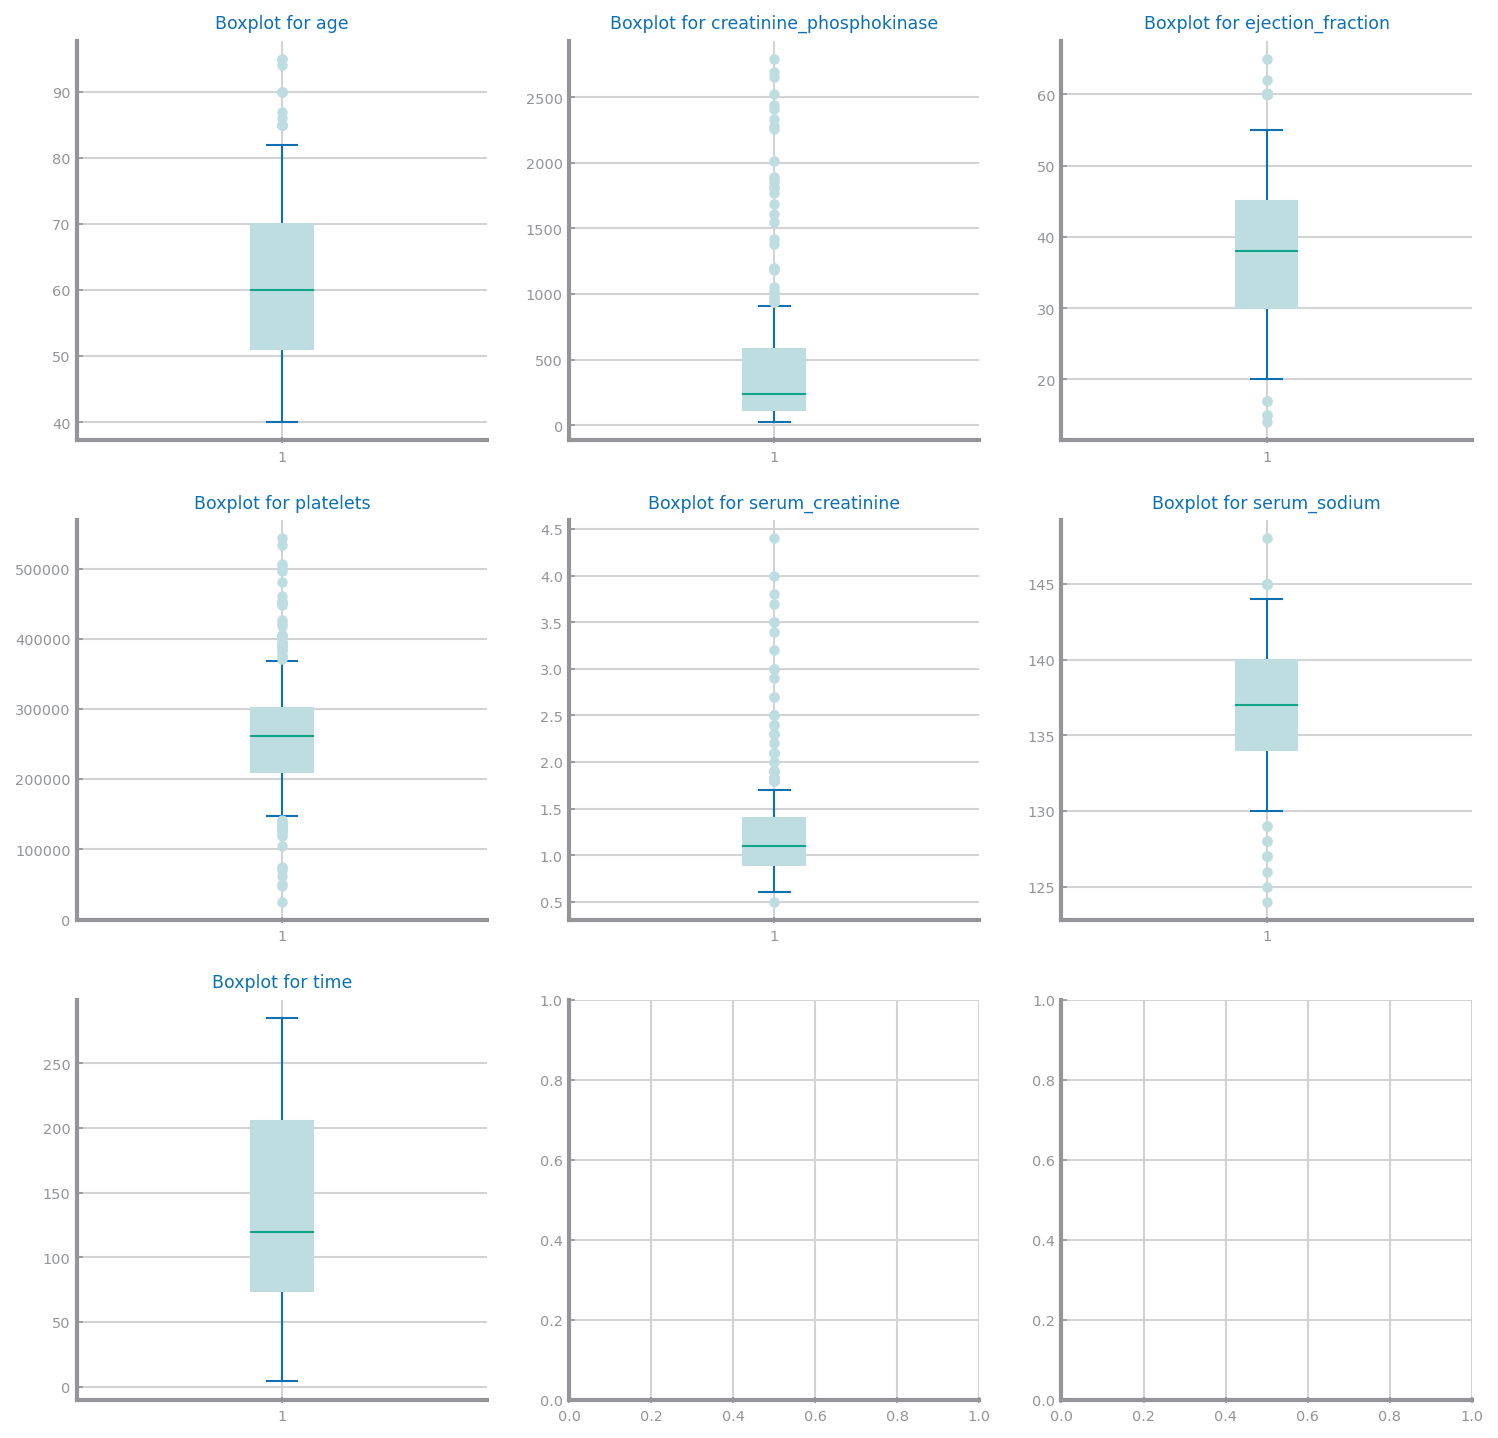

In [6]:
draw_boxplots(data)

In [7]:
data.to_csv(r'../datasets/hf_outliers/HR_outlierTrim_Z.csv')

#### Using IQR
The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1

In [8]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
#print(IQR,"\n")
#print(data < (Q1 - 1.5 * IQR)) or (data > (Q3 + 1.5 * IQR))

print("Before removing outliers:", data.shape)
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
print("After removing outliers:", data.shape)

Before removing outliers: (299, 13)
After removing outliers: (224, 13)


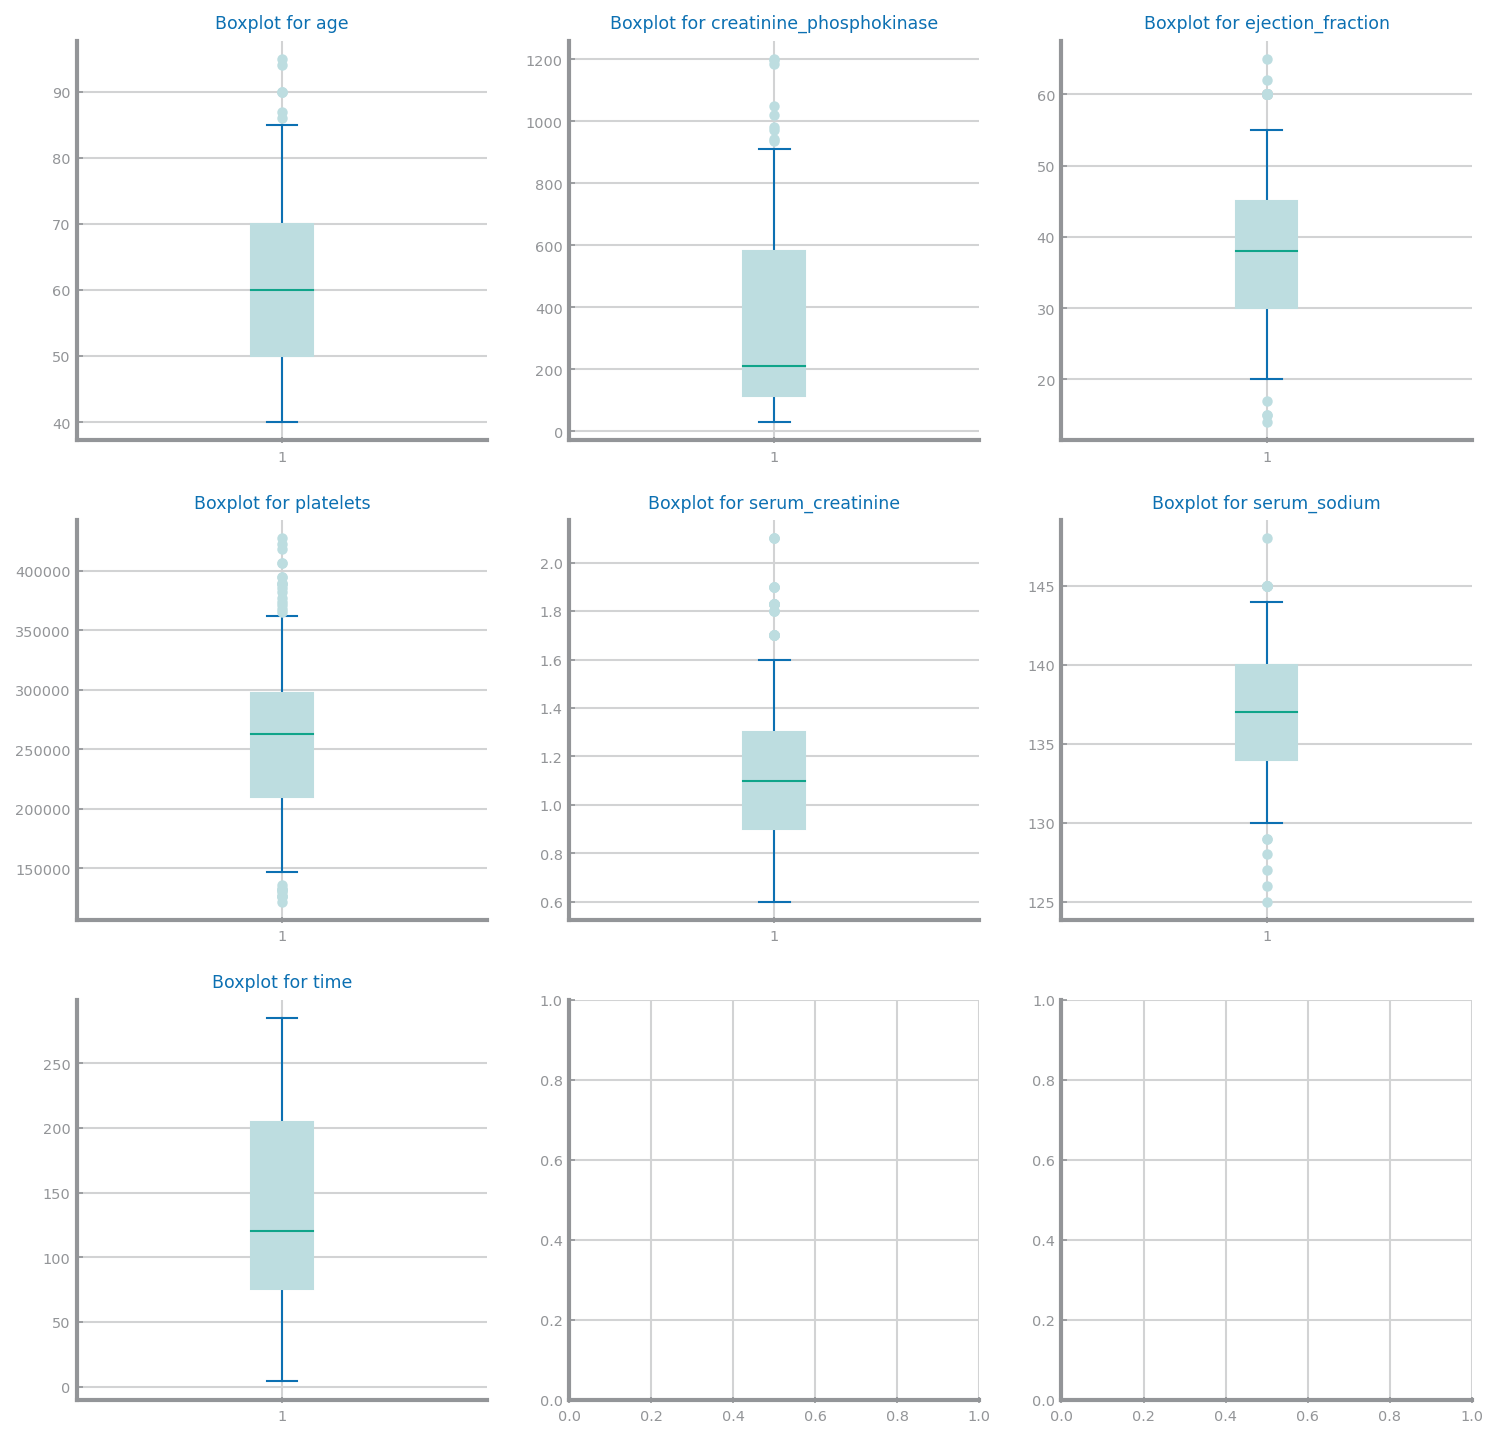

In [9]:
draw_boxplots(data)

In [10]:
data.to_csv(r'../datasets/hf_outliers/HR_outlierTrim_IQS.csv')

### Outliers Imputation - Winsorization

" _This approach involves modifying the weights of outliers or replacing the values being tested for outliers with expected values. The weight modification method allows weight modification without discarding or replacing the values of outliers, limiting the influence of the outliers. The value modification method allows the replacement of the values of outliers with the largest or second smallest value in observations excluding outliers._ "

This can be done using SciPy's Winsorize method which "_returns a Winsorized version of the input array_ " and can be used " _to reduce the effect of possibly spurious outliers by limiting the extreme values_ ".

In [11]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')

for col in data.columns: 
     data[col] = stats.mstats.winsorize(data[col], limits=0.05)

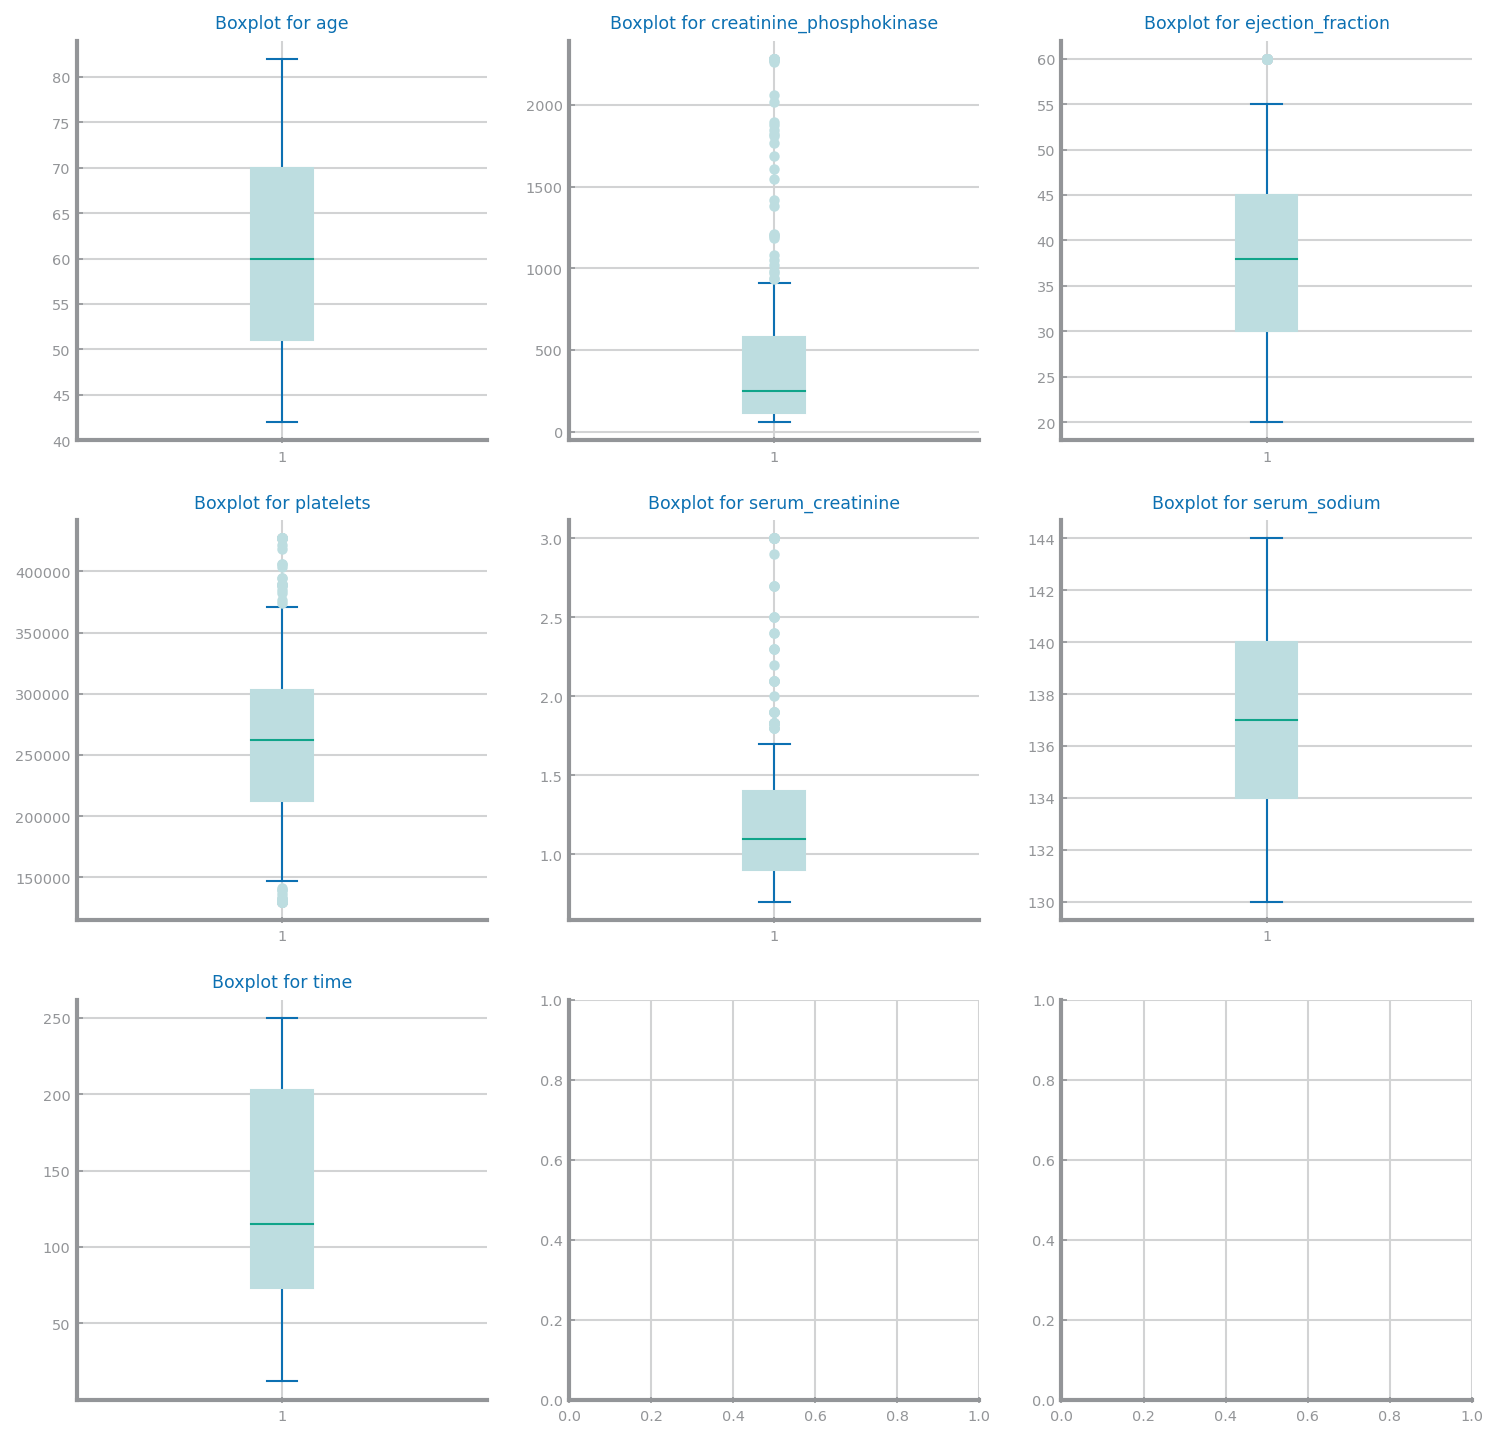

In [12]:
draw_boxplots(data)

In [13]:
data.to_csv(r'../datasets/hf_outliers/HR_outlierWins.csv')

<br/>
<br/>
<br/>
<br/>
<br/>

## Balanced Standardized Heart Failure Dataset

### Imports and data loading

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

data = pd.read_csv('../datasets/HF_balanced_standardized.csv')

### Missing Value Imputation

{'age': 0, 'creatinine_phosphokinase': 0, 'ejection_fraction': 0, 'platelets': 0, 'serum_creatinine': 0, 'serum_sodium': 0, 'time': 0, 'anaemia': 0, 'diabetes': 0, 'high_blood_pressure': 0, 'sex': 0, 'smoking': 0, 'DEATH_EVENT': 0}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text major ticklabel objects>)

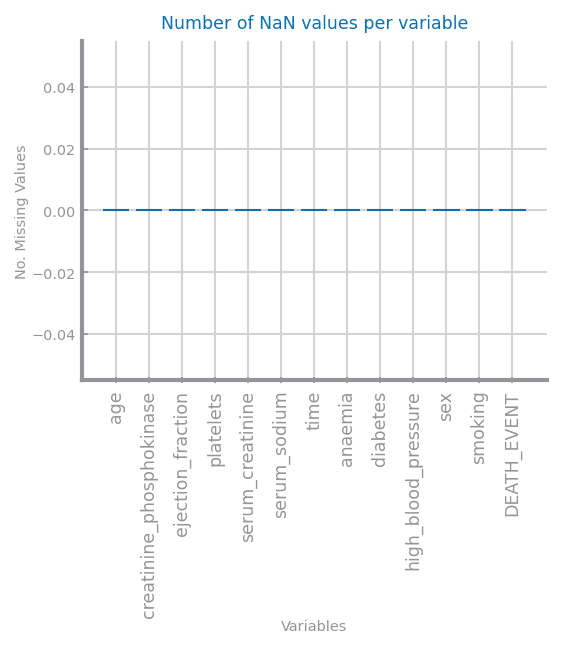

In [15]:
missing_values = {}
for var in data:
    missing_values[var] = data[var].isna().sum()
    
print(missing_values)

plt.figure()

ds.bar_chart(missing_values.keys(), missing_values.values(), title='Number of NaN values per variable',
               xlabel='Variables',
               ylabel='No. Missing Values')

plt.xticks(rotation=90)
#plt.ylim(bottom=0)

This dataset contains no missing values!

### Outliers Imputation - Identification

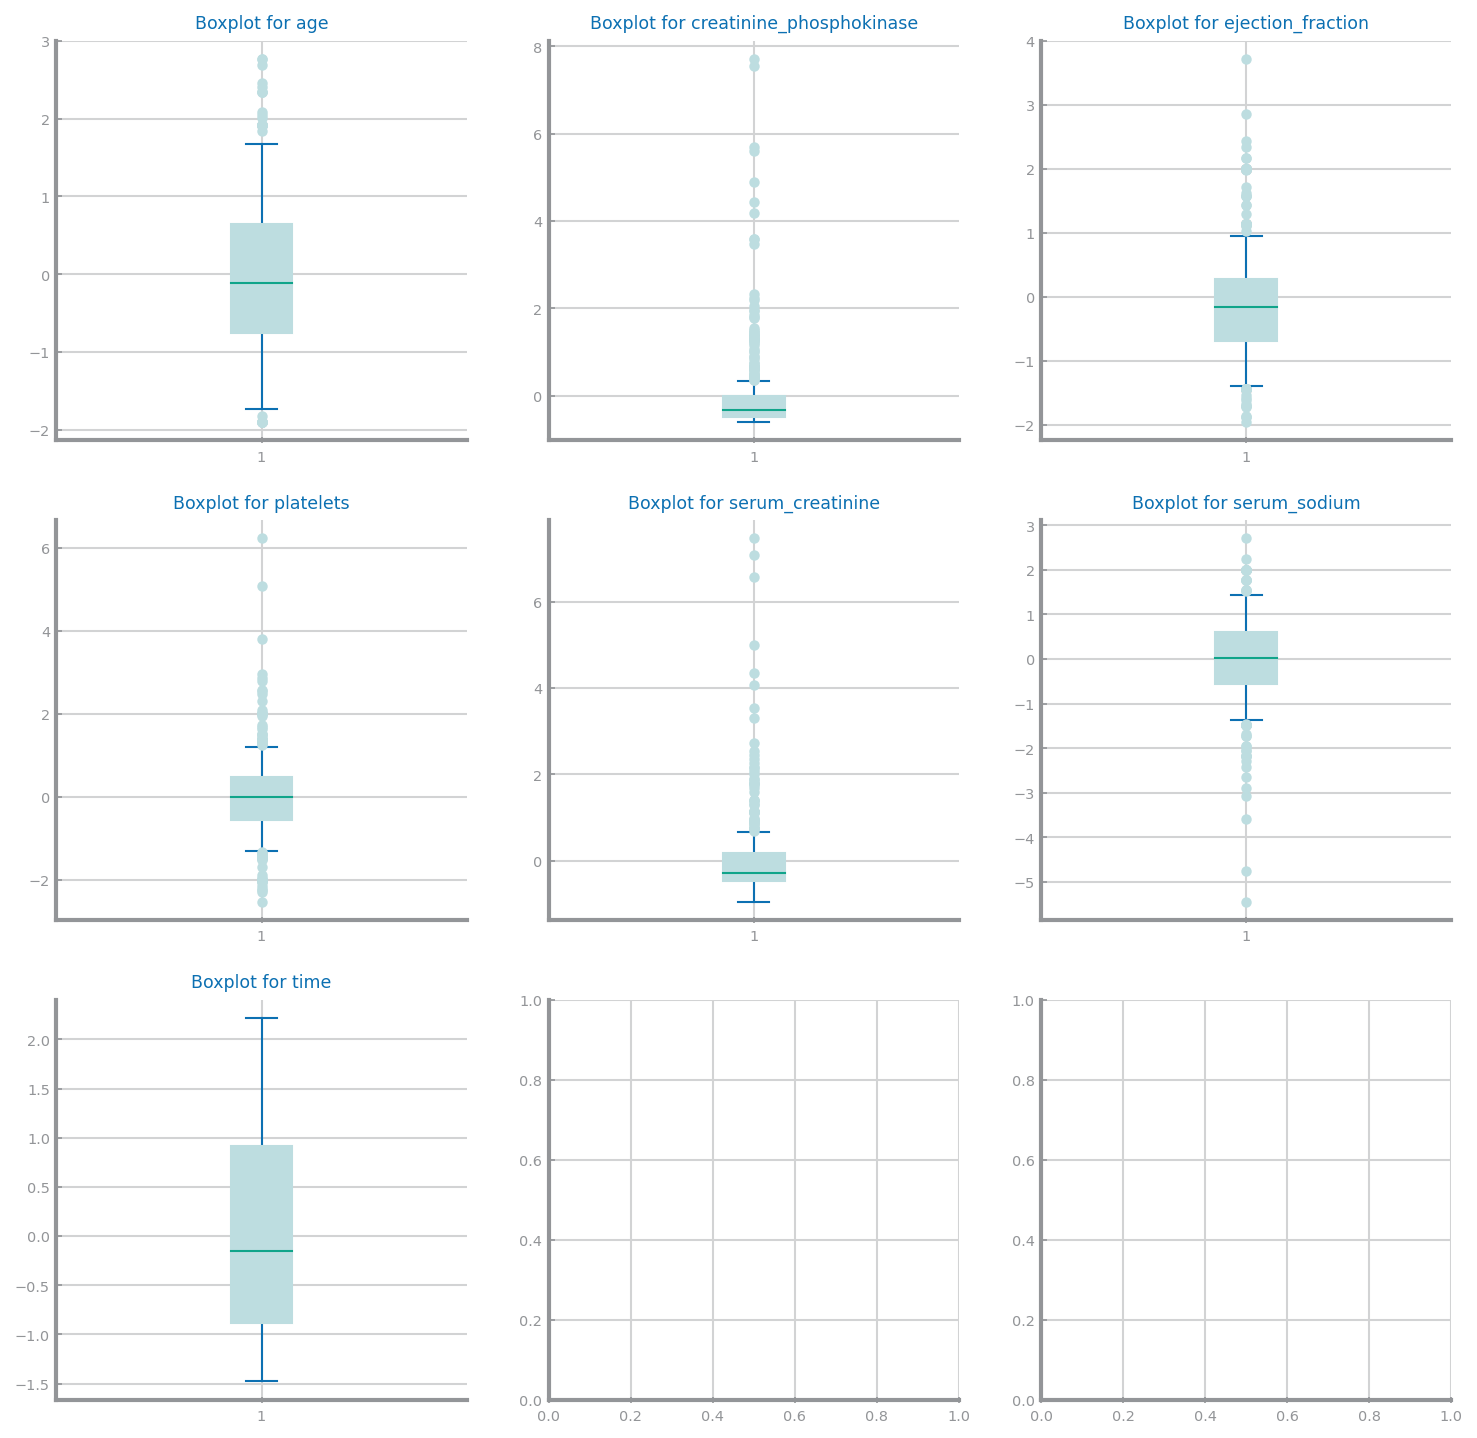

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
0,1.070220,-0.014413,-1.441646,0.014413,0.368836,-1.485883,-1.478952
1,-0.628502,7.713877,0.107863,-0.003003,-0.388152,-0.088779,-1.452648
2,0.220859,-0.477325,-1.441646,-1.078053,-0.198905,-1.718733,-1.439496
3,-1.053183,-0.514485,-1.441646,-0.568943,0.368836,0.144071,-1.439496
4,0.220859,-0.462461,-1.441646,0.672014,1.125825,-4.745791,-1.426344


In [16]:
numeric_vars = data.select_dtypes(include='number').columns
rows, cols = ds.choose_grid(7) #numero de variaveis non bolean
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0

numeric_data = data
binary_data = data

off=0
for n in range(len(numeric_vars)):
    num_unique = len(list(set(data[numeric_vars[n]].values)))
    #only boxplot non boolean vars
    if num_unique == 2:
        off+=1
        numeric_data = numeric_data.drop(columns=[data.columns[n]], axis=1) #Remove binary columns

    else:
        binary_data = binary_data.drop(columns=[data.columns[n]], axis=1) #Remove non-binary columns

        axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
        axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n+1-off) % cols == 0 else (i, j + 1)
plt.show()

numeric_data.head()

By looking at the prior Box Plots for our dataset's numeric variables we can clearly note the presence of outliers on all variables except for Time. On the next sections we'll see how we can treat these.

There are basically three methods for treating outliers in a data set. One method is to **remove outliers** as a means of trimming the data set. Another method involves **replacing the values of outliers or reducing the influence of outliers** through outlier weight adjustments. The third method is used to **estimate the values of outliers** using robust techniques.

In [17]:
def draw_boxplots(data):
    numeric_vars = data.select_dtypes(include='number').columns
    rows, cols = ds.choose_grid(7) #numero de variaveis non bolean
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
    i, j = 0, 0

    numeric_data = data
    binary_data = data

    off=0
    for n in range(len(numeric_vars)):
        num_unique = len(list(set(data[numeric_vars[n]].values)))
        #only boxplot non boolean vars
        if num_unique == 2:
            off+=1
            numeric_data = numeric_data.drop(columns=[data.columns[n]], axis=1) #Remove binary columns

        else:
            binary_data = binary_data.drop(columns=[data.columns[n]], axis=1) #Remove non-binary columns

            axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
            axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
            i, j = (i + 1, 0) if (n+1-off) % cols == 0 else (i, j + 1)
    plt.show()

    numeric_data.head()

### Outliers Imputation - Trimming

" _Under this approach, a data set that excludes outliers is analyzed. The trimmed estimators such as mean decrease the variance in the data and cause a bias based on under- or overestimation. Given that the outliers are also observed values, excluding them from the analysis makes this approach inadequate for the treatment of outliers._ "

Lets start by treating our outliers by simply removing any row that posesses outliers in any column from our dataset. This isn't particularly optimal as explained above, but its easy and fast to do and indeed does get rid of the outliers

#### Using Z-Scores
The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [18]:
data = pd.read_csv('../datasets/HF_balanced_standardized.csv')

z_scores = np.abs(stats.zscore(data))

print("Before removing outliers:", data.shape)
data = data[(z_scores < 3).all(axis=1)]
print("After removing outliers:", data.shape)

Before removing outliers: (406, 13)
After removing outliers: (382, 13)


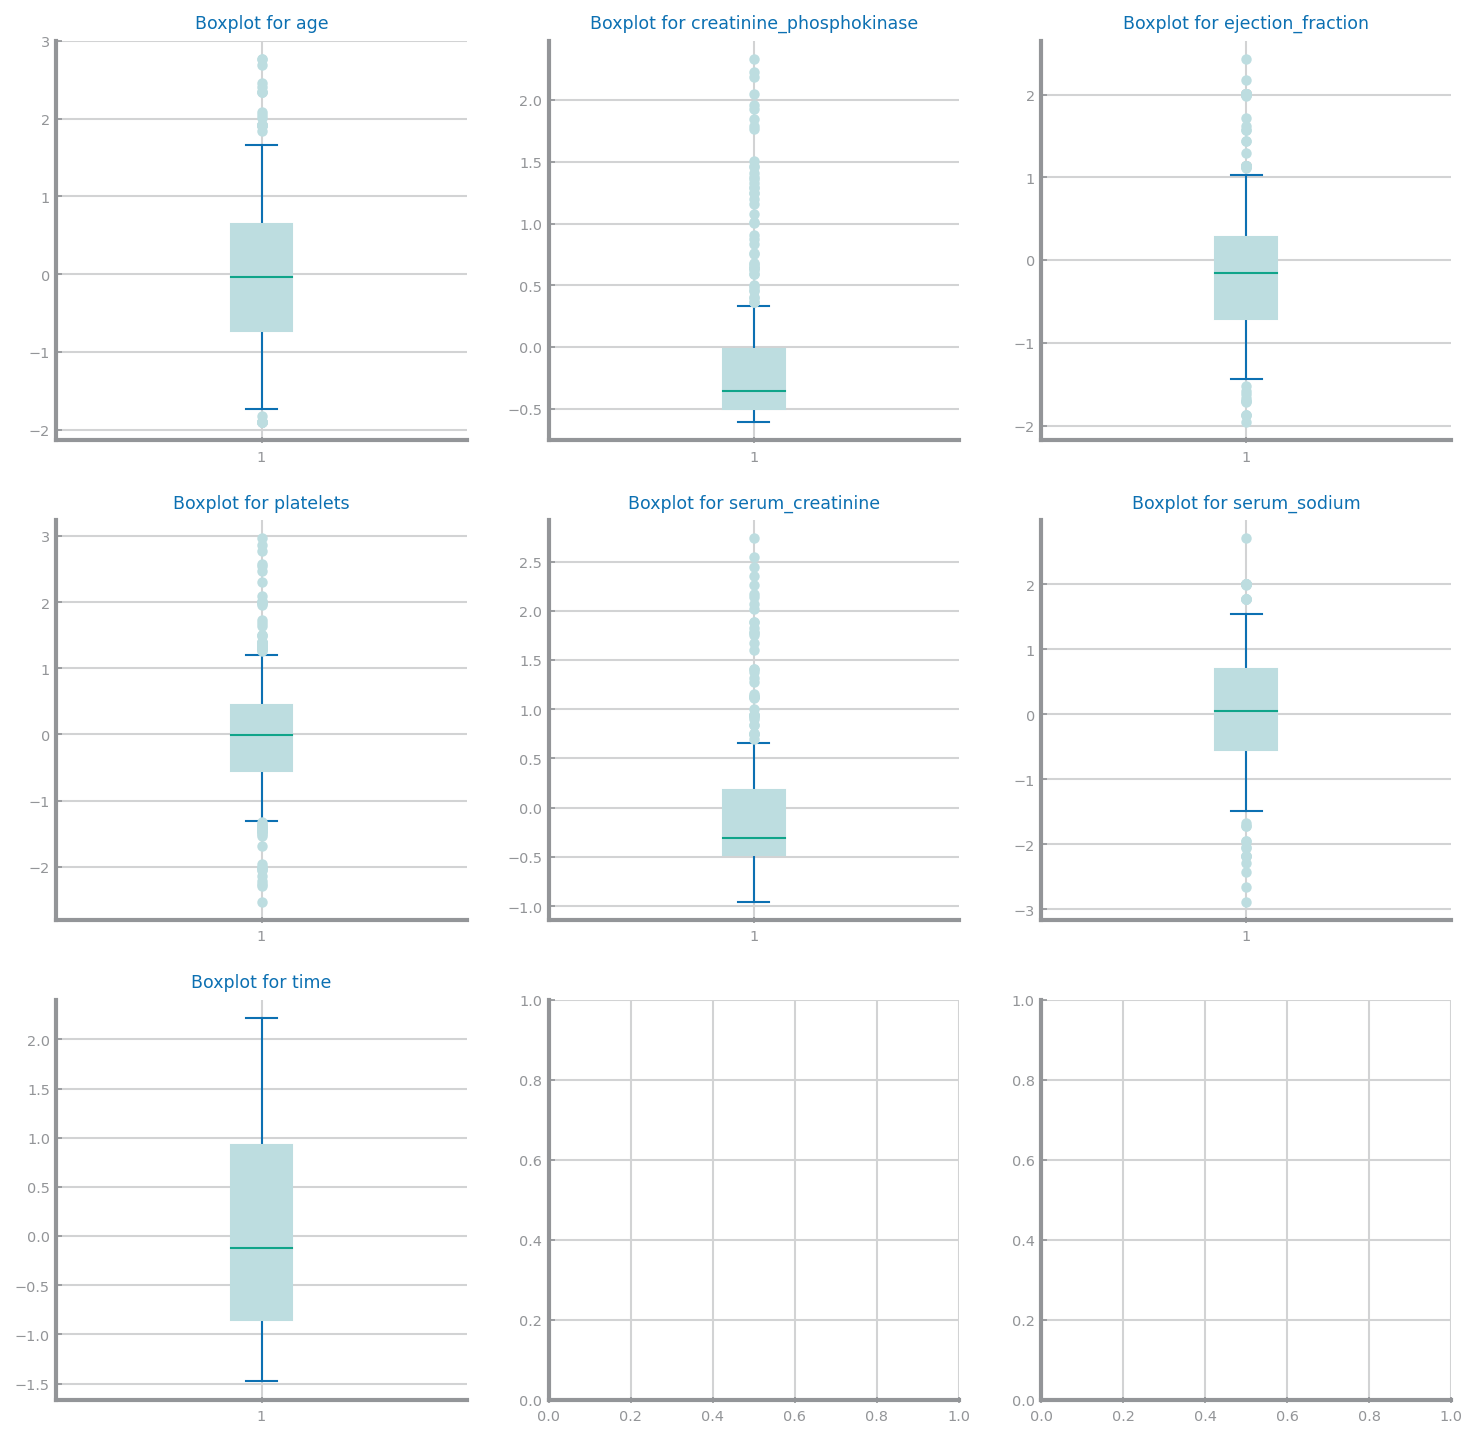

In [19]:
draw_boxplots(data)

In [20]:
data.to_csv(r'../datasets/hf_outliers/HR_BS_outlierTrim_Z.csv')

#### Using IQR
The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1

In [21]:
data = pd.read_csv('../datasets/HF_balanced_standardized.csv')

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
#print(IQR,"\n")
#print(data < (Q1 - 1.5 * IQR)) or (data > (Q3 + 1.5 * IQR))

print("Before removing outliers:", data.shape)
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
print("After removing outliers:", data.shape)

Before removing outliers: (406, 13)
After removing outliers: (284, 13)


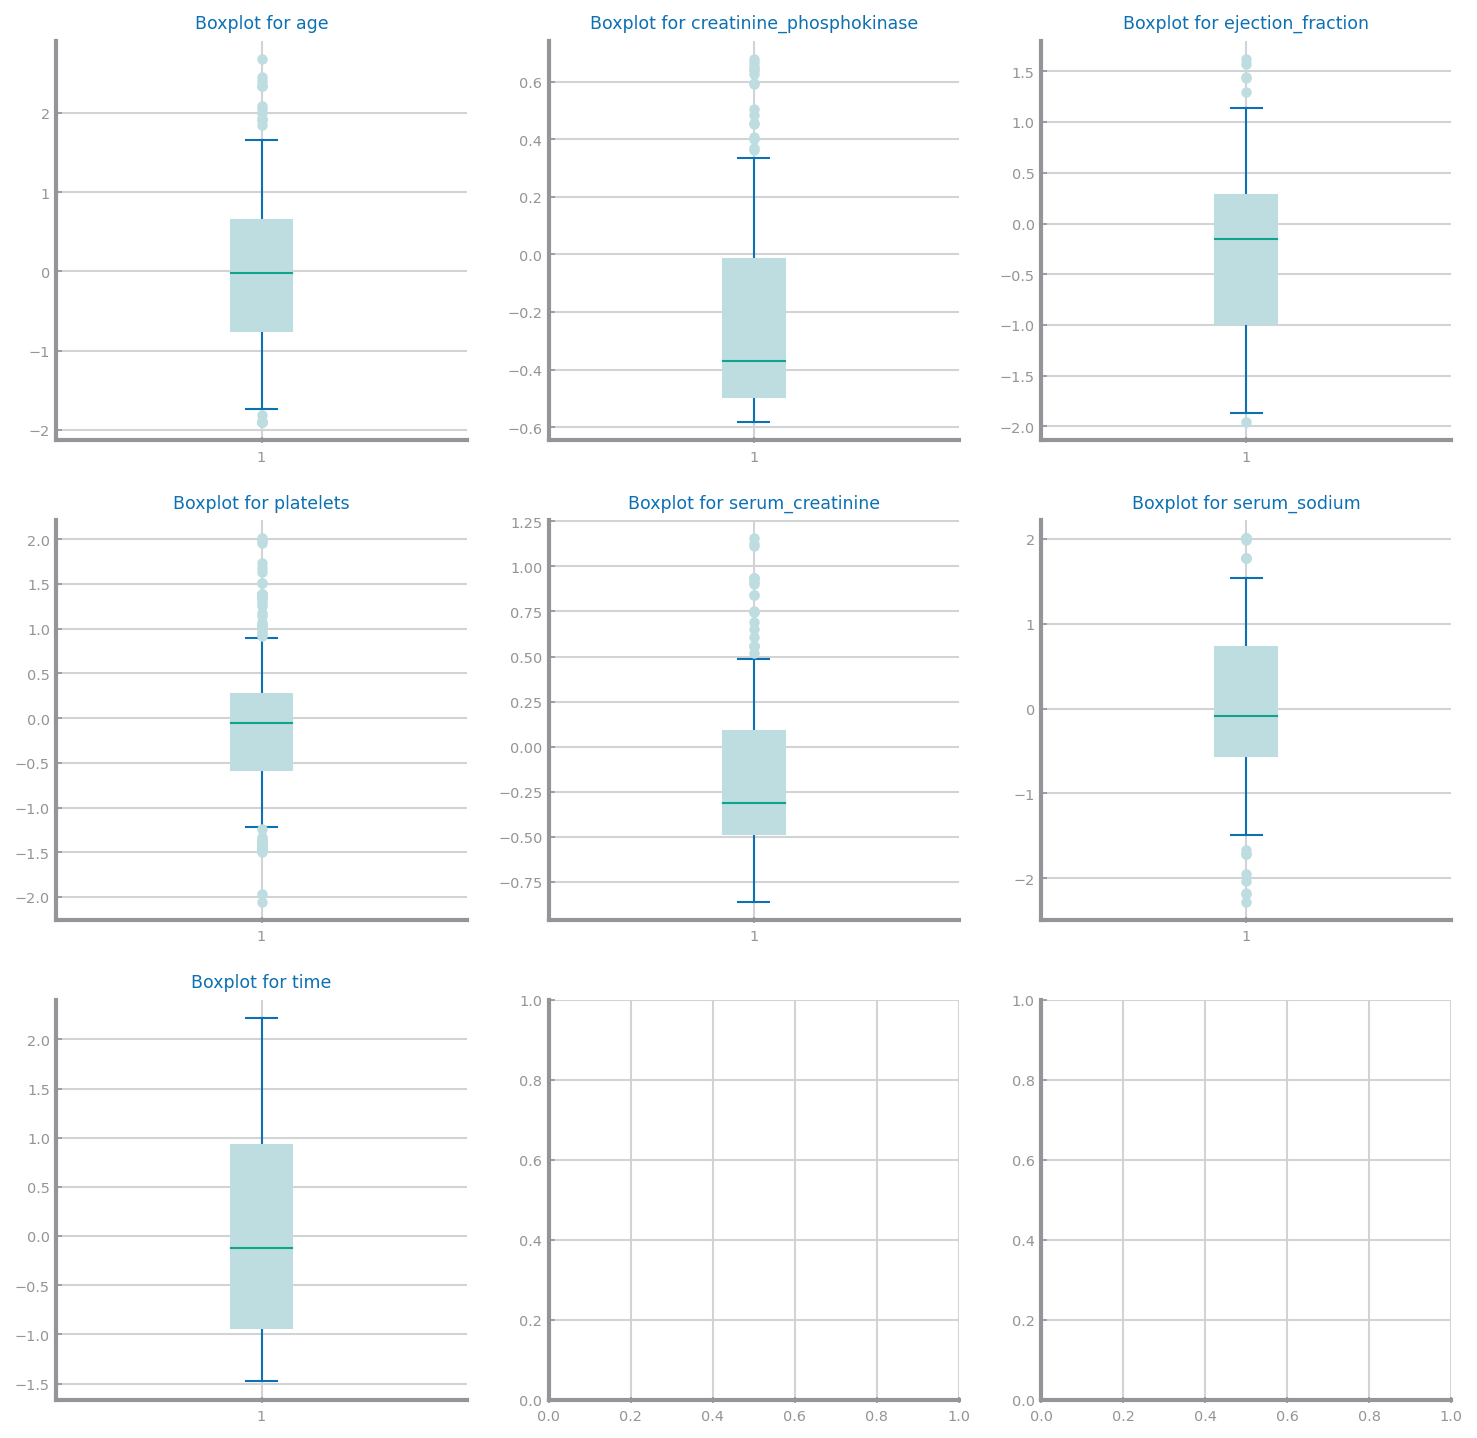

In [22]:
draw_boxplots(data)

In [23]:
data.to_csv(r'../datasets/hf_outliers/HR_BS_outlierTrim_IQS.csv')

### Outliers Imputation - Winsorization

" _This approach involves modifying the weights of outliers or replacing the values being tested for outliers with expected values. The weight modification method allows weight modification without discarding or replacing the values of outliers, limiting the influence of the outliers. The value modification method allows the replacement of the values of outliers with the largest or second smallest value in observations excluding outliers._ "

This can be done using SciPy's Winsorize method which "_returns a Winsorized version of the input array_ " and can be used " _to reduce the effect of possibly spurious outliers by limiting the extreme values_ ".

In [24]:
data = pd.read_csv('../datasets/HF_balanced_standardized.csv')

for col in data.columns: 
     data[col] = stats.mstats.winsorize(data[col], limits=0.05)

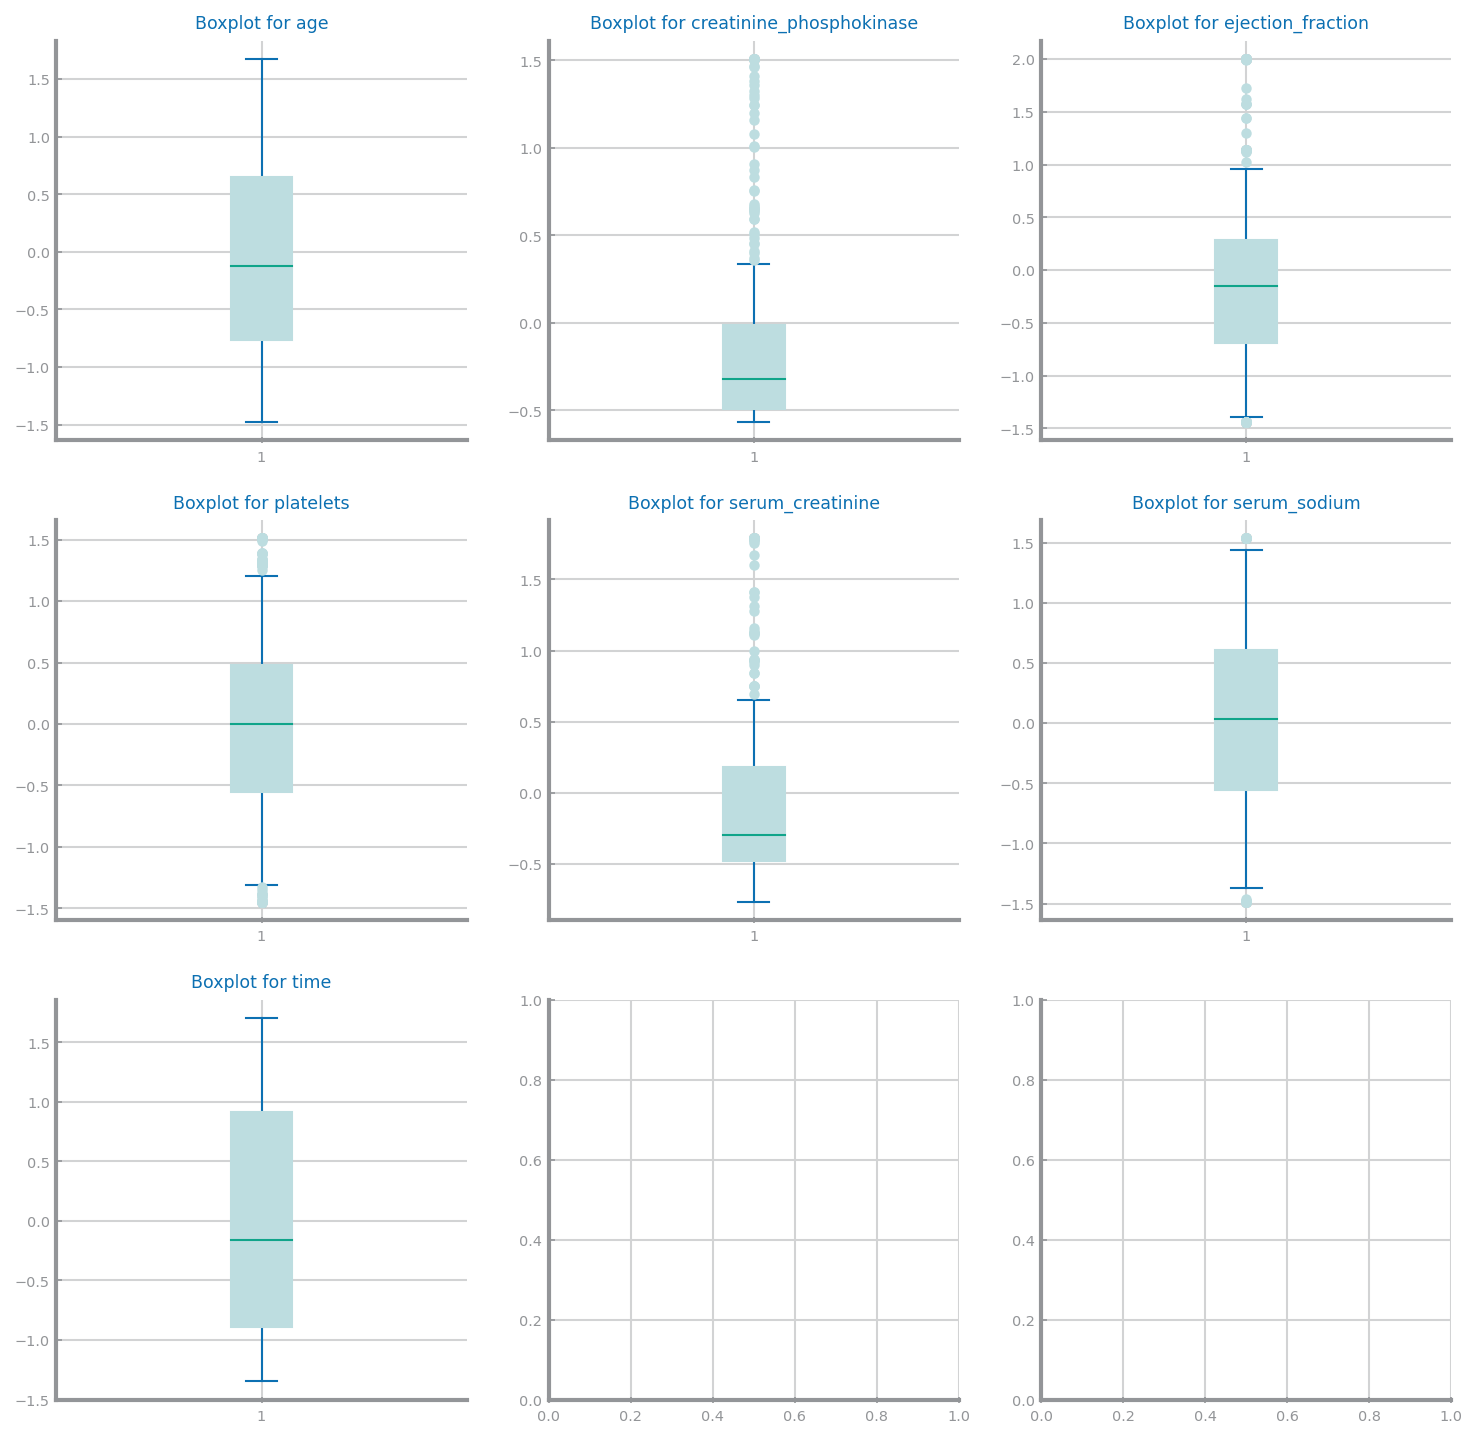

In [25]:
draw_boxplots(data)

In [26]:
data.to_csv(r'../datasets/hf_outliers/HR_BS_outlierWins.csv')

<br/>
<br/>
<br/>
<br/>
<br/>

## QSAR Oral Toxicity Dataset

### Imports and data loading

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

data = pd.read_csv('../datasets/oral_reduced/ORAL_reduced32.csv', sep=';', header=None)

### Missing Value Imputation

{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0}


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 <a list of 33 Text major ticklabel objects>)

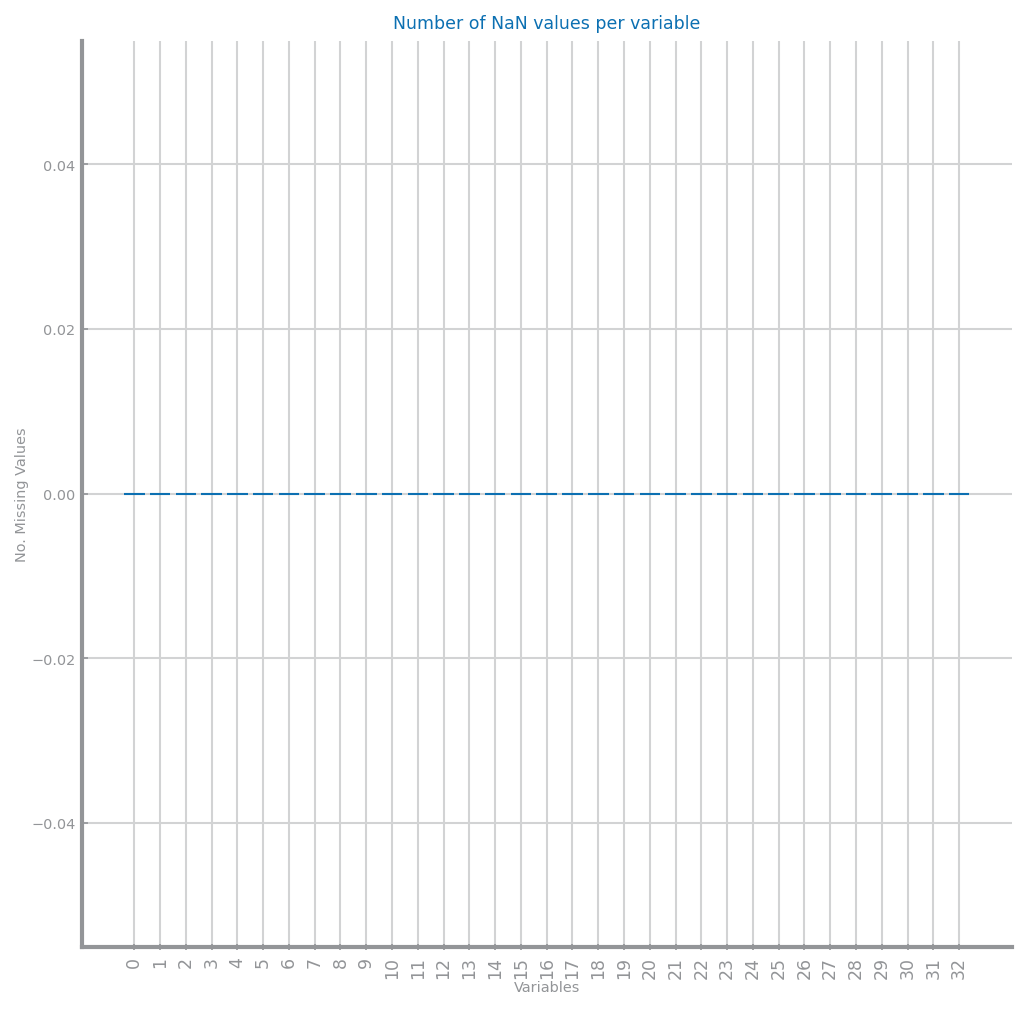

In [28]:
missing_values = {}
for var in data:
    missing_values[str(var)] = data[var].isna().sum()
    
print(missing_values)

plt.figure(figsize=(8,8))

ds.bar_chart(missing_values.keys(), missing_values.values(), title='Number of NaN values per variable',
               xlabel='Variables',
               ylabel='No. Missing Values')

plt.xticks(rotation=90)
#plt.ylim(bottom=0)

This dataset contains no missing values!

### Outliers Imputation - Identification

This dataset is composed of binary variables only, and as such has no outliers!